# Rapport du projet de résolution de problème

- Paul Achard
- Julien Faure

    
- *Date : 20/01/2022*

---

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Problématique

Notre problématique est d'identifier un chiffre à partir d'une image.

## Objectifs

- Trouver un modèle permettant d'identifier un chiffre à partir d'une image
- Comparer différentes stratégies de solveur pour le modèle trouvé

## Analyse du dataset

Identifier un chiffre à partir d'une image est une tache qui peut s'avérer très complexe. Afin d'avoir une difficulté raisonnable et adapté au contexte de ce projet, nous avons fixé certains paramètres dans notre dataset.

- La résolution de nos images est identiques pour tout le dataset. Cette résolution est **8 pixels par 8 pixels**.
- Chaque pixel est codé sur **4 bits**.
- Les images contiennent uniquement un chiffre sans élément parasite, sans effet et sans traitement.

Nous utilisons le dataset `digits` de `seaborn`.

### Forme du dataset

In [5]:
# Import du dataset
digits = datasets.load_digits()

# Affiche le nombre d'images et leur format
print("Image Data Shape" , digits.data.shape)

# Affiche le nombre de labels
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


Comme nous pouvons le voir ci-dessus, le dataset est composé de **1797** images labellisées.

### Répartition des images du dataset

[Text(0.5, 0, 'n° labellisé'), Text(0, 0.5, 'Occurrence')]

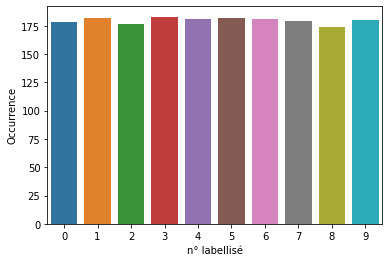

In [6]:
graphique = sns.countplot(x=digits.target)
graphique.set(xlabel="n° labellisé", ylabel = "Occurrence")

Les données labellisées sont équitablement distribuées (environ 175 par label).

### Représentation des données

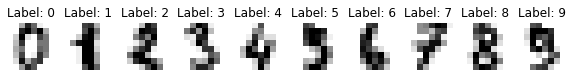

In [7]:
# Création de 10 figures de 10 par 3 pixels
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))

# Pour chaque figure, on affiche l'image du chiffre et son label en titre
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Label: %i" % label)

### Représentation des images

In [8]:
# Affiche le tableau représentant la première image
print(digits.images[0])
print("\n Type de chaque valeur :", type(digits.images[0][0][0]))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]

 Type de chaque valeur : <class 'numpy.float64'>


> Comme nous l'avons vu précédemment, chaque image possède une résolution de 8x8 pixels en niveaux de gris codés sur 4bits par pixel.

Dans notre programme, une image est représentée par une matrice de dimension 8x8. Chaque élément représente un pixel avec un niveau de gris codé sur 4bits (de 0 à 15). Plus la valeur est élevée, plus la couleur est foncée.

> Exemple :
* 0 : Blanc
* 15 : Noir


## Modèle



Pour résoudre notre problème, il existe plusieurs modèles possibles :
* Modèle de régression logistique.
* 

### Régression 

In [9]:
# Redimensionne le tableau en vecteur
print(digits.images[0].reshape(-1))

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

x = digits.images.reshape((len(digits.images), -1))
y = digits.target

# séparation du dataset en données "d'apprentissage" et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

# Création du modèle de régression
lRModel = LogisticRegression(verbose=False, max_iter=10000)

# dictionnaire contenant les différents paramètres à essayer
paramDict = dict()
paramDict['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
paramDict['penalty'] = ['l2', 'none']
paramDict['C'] = [0.1,5 , 10]

# Création de nos itérations
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Création de notre modèle de validation croisée
model_cv = GridSearchCV(estimator=lRModel,
                        param_grid=paramDict,
                        scoring='accuracy',
                        cv=kFold,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True)

# Entrainement du modèle
model_cv.fit(x_train, y_train)
# cv results
pd.set_option('display.max_columns', None)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 15 folds for each of 18 candidates, totalling 270 fits


e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 464, in _check_solv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.681888,0.071425,0.000400,0.000490,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.954861,0.958333,0.972125,0.968641,0.979094,0.961806,0.968750,0.982578,0.965157,0.965157,0.965278,0.968750,0.961672,0.958188,0.958188,0.965905,0.007523,1,1.000000,1.000000,1.000000,0.999130,1.000000,0.999130,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999884,0.000296
1,1.798371,0.689899,0.000534,0.000499,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.954861,0.958333,0.972125,0.968641,0.979094,0.961806,0.968750,0.982578,0.965157,0.965157,0.965278,0.968750,0.961672,0.958188,0.958188,0.965905,0.007523,1,1.000000,1.000000,1.000000,0.999130,1.000000,0.999130,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999884,0.000296
2,0.081474,0.007299,0.000467,0.000499,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.958333,0.958333,0.961672,0.961672,0.958188,0.965278,0.968750,0.982578,0.958188,0.951220,0.975694,0.961806,0.958188,0.947735,0.972125,0.962651,0.008771,3,0.992167,0.993908,0.995652,0.993043,0.993043,0.991297,0.996519,0.992174,0.993043,0.993913,0.990426,0.992167,0.993913,0.993913,0.995652,0.993389,0.001615
3,0.162815,0.010653,0.000267,0.000443,0.1,none,newton-cg,"{'C': 0.1, 'penalty': 'none', 'solver': 'newto...",0.944444,0.954861,0.965157,0.951220,0.961672,0.947917,0.958333,0.965157,0.958188,0.951220,0.965278,0.951389,0.937282,0.961672,0.951220,0.955001,0.007974,11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.060589,0.013825,0.000801,0.001722,0.1,none,lbfgs,"{'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}",0.944444,0.951389,0.961672,0.958188,0.958188,0.958333,0.951389,0.958188,0.947735,0.961672,0.965278,0.965278,0.944251,0.951220,0.958188,0.955694,0.006658,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.000534,0.000499,0.000000,0.000000,0.1,none,liblinear,"{'C': 0.1, 'penalty': 'none', 'solver': 'libli...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.891478,0.133195,0.000534,0.000499,5,l2,newton-cg,"{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}",0.944444,0.958333,0.965157,0.965157,0.968641,0.965278,0.958333,0.979094,0.965157,0.958188,0.965278,0.968750,0.951220,0.961672,0.951220,0.961728,0.008223,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,2.350740,0.449218,0.000400,0.000490,5,l2,lbfgs,"{'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.944444,0.958333,0.965157,0.965157,0.968641,0.965278,0.958333,0.979094,0.965157,0.958188,0.965278,0.968750,0.951220,0.961672,0.951220,0.961728,0.008223,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.146600,0.006981,0.000400,0.000490,5,l2,liblinear,"{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",0.947917,0.947917,

La validation croisée nous permet de determiner les paramètres optimaux pour notre modèle d'apprentissage.
Les résultats de nos tests avec de nombreux paramètres différents (dont la plupart ne sont pas présent dans l'exemple ci-dessus).
#TODO mettre dans une liste
Le paramètre C correspond à l'inverse de la force de régularisation des données. Plus ce paramètre est grand, plus le risque d'overfitting est grand. Une valeur de 0.1 semble être optimale.
Le paramètre de pénalité permet de réduire les coefficients θ. On remarque une perte de précision si l'on n'applique pas de pénalité. La meilleure pénalité semble être la norme L2.
Pour finir, le solveur correspond à l'algorithme d'optimisation utilisé pour l'entrainement. Dans notre cas, lbfgs permet d'obtenir la precision la plus élevée malgré un temps d'entrainement significativement plus long que ses concurrents.

Modèle de Bayes

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=5, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(RCV.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003003,0.001096,0.000467,0.000499,0.01,{'alpha': 0.01},0.888889,0.836806,0.867596,0.867596,0.857143,0.878472,0.833333,0.871080,0.871080,0.867596,0.885417,0.854167,0.853659,0.874564,0.871080,0.865232,0.015267,1
1,0.002602,0.000712,0.000534,0.000499,0.1,{'alpha': 0.1},0.881944,0.833333,0.864111,0.864111,0.867596,0.871528,0.833333,0.871080,0.874564,0.860627,0.881944,0.843750,0.857143,0.871080,0.867596,0.862916,0.014765,2
2,0.002402,0.000490,0.000601,0.000490,0.5,{'alpha': 0.5},0.878472,0.826389,0.857143,0.860627,0.864111,0.868056,0.822917,0.867596,0.871080,0.857143,0.878472,0.836806,0.853659,0.860627,0.867596,0.858046,0.016422,3
3,0.002202,0.000400,0.000801,0.000400,1.0,{'alpha': 1.0},0.878472,0.822917,0.857143,0.857143,0.860627,0.868056,0.822917,0.867596,0.871080,0.857143,0.878472,0.836806,0.850174,0.860627,0.867596,0.857118,0.016874,4
4,0.002202,0.000654,0.000400,0.000490,10.0,{'alpha': 10.0},0.875000,0.805556,0.860627,0.850174,0.846690,0.850694,0.798611,0.864111,0.860627,0.860627,0.871528,0.815972,0.839721,0.846690,0.860627,0.847150,0.022390,5


In [12]:
from sklearn.tree import DecisionTreeClassifier

#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "min_samples_leaf": [1,2,3,4],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

DT = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(DT.cv_results_)
cv_results

e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005472,0.000619,0.000400,0.000490,best,1,3,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.489583,0.468750,0.456446,0.473868,0.463415,0.482639,0.444444,0.463415,0.477352,0.477352,0.461806,0.486111,0.452962,0.494774,0.470383,0.470887,0.013688,29
1,0.002202,0.000542,0.000334,0.000472,random,1,3,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.555556,0.489583,0.480836,0.505226,0.484321,0.493056,0.531250,0.425087,0.421603,0.543554,0.531250,0.468750,0.414634,0.533101,0.550523,0.495222,0.045506,26
2,0.005205,0.000401,0.000200,0.000401,best,2,3,gini,"{'splitter': 'best', 'min_samples_leaf': 2, 'm...",0.489583,0.468750,0.456446,0.473868,0.463415,0.482639,0.444444,0.463415,0.477352,0.477352,0.461806,0.486111,0.452962,0.494774,0.470383,0.470887,0.013688,29
3,0.002402,0.000611,0.000200,0.000400,random,2,3,gini,"{'splitter': 'random', 'min_samples_leaf': 2, ...",0.506944,0.486111,0.567944,0.480836,0.515679,0.371528,0.454861,0.358885,0.456446,0.543554,0.458333,0.496528,0.554007,0.435540,0.557491,0.482979,0.060828,27
4,0.004804,0.000400,0.000334,0.000472,best,3,3,gini,"{'splitter': 'best', 'min_samples_leaf': 3, 'm...",0.489583,0.468750,0.456446,0.473868,0.463415,0.482639,0.444444,0.463415,0.477352,0.477352,0.461806,0.486111,0.452962,0.494774,0.470383,0.470887,0.013688,29
5,0.002069,0.000443,0.000334,0.000472,random,3,3,gini,"{'splitter': 'random', 'min_samples_leaf': 3, ...",0.520833,0.475694,0.487805,0.439024,0.491289,0.569444,0.513889,0.498258,0.529617,0.414634,0.434028,0.434028,0.435540,0.456446,0.505226,0.480384,0.042554,28
6,0.004537,0.000499,0.000467,0.000499,best,4,3,gini,"{'splitter': 'best', 'min_samples_leaf': 4, 'm...",0.489583,0.468750,0.456446,0.473868,0.463415,0.482639,0.444444,0.463415,0.477352,0.477352,0.461806,0.486111,0.452962,0.494774,0.470383,0.470887,0.013688,29
7,0.002202,0.000400,0.000334,0.000472,random,4,3,gini,"{'splitter': 'random', 'min_samples_leaf': 4, ...",0.517361,0.430556,0.533101,0.543554,0.473868,0.534722,0.496528,0.554007,0.519164,0.557491,0.534722,0.524306,0.456446,0.533101,0.494774,0.513580,0.035267,22
8,0.011277,0.000681,0.000467,0.000499,best,1,None,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.854167,0.847222,0.850174,0.839721,0.811847,0.836806,0.812500,0.860627,0.815331,0.850174,0.833333,0.812500,0.867596,0.864111,0.846690,0.840187,0.018692,6
9,0.005071,0.000772,0.000400,0.000490,random,1,None,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.840278,0.847222,0.843206,0.860627,0.836237,0.847222,0.861111,0.846690,0.853659,0.871080,0.864583,0.840278,0.832753,0.850174,0.860627,0.850383,0.010851,2


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Building Gradient Boosting Classifier

GB_model = GradientBoostingClassifier()
param_dist = {
    "n_estimators":[5,20,100],
    "max_depth":[3,5,7],
    "learning_rate":[0.01,0.1,1,10]
}

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, param_dist, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

GB = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(GB.cv_results_)
cv_results

e:\dev\machine_learning\tp\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.177328,0.019438,0.001501,5.004009e-04,5,3,0.01,"{'n_estimators': 5, 'max_depth': 3, 'learning_...",0.769124,0.753482,0.757997,0.785515,0.732962,0.771588,0.761778,0.016468,33
1,0.681621,0.023324,0.002336,4.718200e-04,20,3,0.01,"{'n_estimators': 20, 'max_depth': 3, 'learning...",0.824757,0.784123,0.821975,0.821727,0.802503,0.828691,0.813963,0.015704,23
2,3.303007,0.063671,0.010343,4.715393e-04,100,3,0.01,"{'n_estimators': 100, 'max_depth': 3, 'learnin...",0.865090,0.853760,0.888734,0.866295,0.849791,0.874652,0.866387,0.012937,14
3,0.262572,0.006215,0.002002,3.576279e-07,5,5,0.01,"{'n_estimators': 5, 'max_depth': 5, 'learning_...",0.801113,0.786908,0.812239,0.803621,0.801113,0.814763,0.803293,0.009034,26
4,1.116016,0.043078,0.004004,2.753021e-07,20,5,0.01,"{'n_estimators': 20, 'max_depth': 5, 'learning...",0.826147,0.803621,0.841446,0.834262,0.806676,0.841226,0.825563,0.015339,19
5,5.776259,0.108986,0.017516,1.385715e-03,100,5,0.01,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.847010,0.832869,0.887344,0.867688,0.847010,0.870474,0.858732,0.018168,15
6,0.374174,0.019065,0.002002,1.638375e-07,5,7,0.01,"{'n_estimators': 5, 'max_depth': 7, 'learning_...",0.835883,0.779944,0.812239,0.818942,0.777469,0.824513,0.808165,0.022011,24
7,1.582107,0.011378,0.005505,5.003612e-04,20,7,0.01,"{'n_estimators': 20, 'max_depth': 7, 'learning...",0.833102,0.799443,0.830320,0.821727,0.798331,0.825905,0.818138,0.014067,22
8,8.565132,0.167357,0.024022,1.000841e-03,100,7,0.01,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.838665,0.805014,0.835883,0.818942,0.806676,0.828691,0.822312,0.013212,20
9,0.175660,0.010494,0.001668,4.718763e-04,5,3,0.1,"{'n_estimators': 5, 'max_depth': 3, 'learning_...",0.852573,0.827298,0.847010,0.839833,0.816412,0.855153,0.839713,0.013869,17


Citation :
Stephanie Glen. "Regularization: Simple Definition, L1 & L2 Penalties" From StatisticsHowTo.com: Elementary Statistics for the rest of us! https://www.statisticshowto.com/regularization/